<a href="https://colab.research.google.com/github/jayeshp19/multi-agent-systems/blob/main/restaurant_supervisor_multiagent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Graphs
At its core, LangGraph models agent workflows as graphs. We can define the behavior of agents using three key components:

#### State:
- A shared data structure that represents the current snapshot of our application. It can be any Python type, but is typically a TypedDict or Pydantic BaseModel.

#### Nodes:
- Python functions that encode the logic of agents. They receive the current State as input, perform some computation or side-effect, and return an updated State.

#### Edges:
- Python functions that determine which Node to execute next based on the current State. They can be conditional branches or fixed transitions.

By composing Nodes and Edges, we can create complex, looping workflows that evolve the State over time. To emphasize: Nodes and Edges are nothing more than Python functions - they can contain an LLM or just good ol' Python code.

In short: nodes do the work. edges tell what to do next.

##### Reference : [LangGraph Glossary](https://langchain-ai.github.io/langgraph/concepts/low_level/)

### Multi-agent Systems:
There are several ways to connect agents in a multi-agent system:

#### Network Agent:
- each agent can communicate with every other agent. Any agent can decide which other agent to call next.
#### Supervisor Agent:
- each agent communicates with a single supervisor agent. Supervisor agent makes decisions on which agent should be called next.
#### Supervisor (tool-calling) Agent:
- this is a special case of supervisor architecture. Individual agents can be represented as tools. In this case, a supervisor agent uses a tool-calling LLM to decide which of the agent tools to call, as well as the arguments to pass to those agents.
#### Hierarchical Agent:
- we can define a multi-agent system with a supervisor of supervisors. This is a generalization of the supervisor architecture and allows for more complex control flows.
#### Custom multi-agent workflow:
- each agent communicates with only a subset of agents. Parts of the flow are deterministic, and only some agents can decide which other agents to call next.


##### Reference : [Multi-agent Systems](https://langchain-ai.github.io/langgraph/concepts/multi_agent/)

In Below Example I'm using supervisor agent for restaurant booking


![title](https://github.com/jayeshp19/multi-agent-systems/blob/main/rsm_concept.png?raw=1)
![title](https://github.com/jayeshp19/multi-agent-systems/blob/main/rsm.png?raw=1)

In [ ]:
%%capture --no-stderr
%pip install -U langgraph langchain langchain_openai langchain_experimental langsmith pandas

In [ ]:
import getpass
import os
# from dotenv import load_dotenv
# load_dotenv(override=True)
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")
_set_if_undefined("OPENAI_API_KEY")


In [ ]:
# Create Tools
from typing import Annotated
from langchain.tools import tool
@tool
def check_availability(
    date: Annotated[str, "date in YYYY-MM-DD format"],
    time: Annotated[str, "time for the day, i.e. Morning, Afternoon, Evening"]
) -> str:
    """Checks availability for restaurant reservation."""
    try:
        return f"Available for {date} {time}"
    except Exception as e:
        raise

@tool
def book_reservation(
    name: Annotated[str, "Name of person"],
    count: Annotated[int, "The count of people"]
) -> str:
    """Books a restaurant reservation."""
    try:
        return f"Successfully booked for {name} (party of {count})"
    except Exception as e:
        raise

In [ ]:
# Define Agent State
import operator
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str

Define Supervisor Agent

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from typing import Literal


SYSTEM_PROMPT = """
You are a supervisor managing a restaurant booking workflow with these team members:
{members}

Team responsibilities:
- Frontdesk: Validates availability and handles initial customer inquiries
- Booking: Processes final reservation booking after availability is confirmed

Workflow rules:
1. Frontdesk MUST check availability first
2. Booking can only process after availability is confirmed
3. Respond with FINISH when:
   - User's request is completed or question is answered
   - Booking is successfully completed
   - Request cannot be fulfilled
   - Error occurs that cannot be resolved

Current conversation follows. Who should act next or should we FINISH?
"""

members = ["Frontdesk", "Booking", "User"]

class RouteResponse(BaseModel):
    next: Literal["FINISH", "Frontdesk", "Booking", "User"] = Field(
        description="Next action to take in the workflow"
    )

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYSTEM_PROMPT),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(["FINISH"] + members), members=", ".join(members))


llm = ChatOpenAI(model="gpt-4o-mini")

def supervisor_agent(state):
    supervisor_chain = prompt | llm.with_structured_output(RouteResponse)
    return supervisor_chain.invoke(state)

def human_feedback(state):
    print({state['messages'][-1].content})
    user_input = input()
    return {
        "messages": [HumanMessage(content=user_input)]
    }

In [ ]:
# Create agent Nodes
import functools
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import HumanMessage

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }

# We are using LangGraph's prebuilt create_react_agent, which creates simple re-act agent
frontdesk_agent = create_react_agent(llm, state_modifier = "You're a helpful frontdesk receptionist at Restaurant" , tools=[check_availability])
booking_agent = create_react_agent(llm,state_modifier = "You're a helpful Booking agent for Restaurant reservation" , tools=[book_reservation])

frontdesk_node = functools.partial(
    agent_node, agent=frontdesk_agent, name="Frontdesk"
)
booking_node = functools.partial(
    agent_node, agent=booking_agent, name="Booking"
)

In [ ]:
 # Initialize workflow
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("Frontdesk", frontdesk_node)
workflow.add_node("Booking", booking_node)
workflow.add_node("supervisor", supervisor_agent)
workflow.add_node("User", human_feedback)

# Configure edges
for member in members:
    workflow.add_edge(member, "supervisor")

conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    conditional_map
)

workflow.add_edge(START, "supervisor")

In [ ]:
graph = workflow.compile()

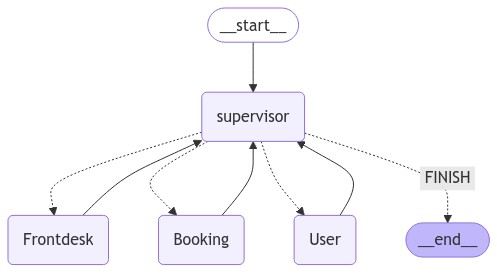

In [ ]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="I want to book a seat tomorrow")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Frontdesk'}}
----
{'Frontdesk': {'messages': [HumanMessage(content='Could you please provide me with the time you would like to book the seat for tomorrow? The options are Morning, Afternoon, or Evening.', additional_kwargs={}, response_metadata={}, name='Frontdesk')]}}
----
{'supervisor': {'next': 'User'}}
----
{'Could you please provide me with the time you would like to book the seat for tomorrow? The options are Morning, Afternoon, or Evening.'}


 Evening


{'User': {'messages': [HumanMessage(content='Evening', additional_kwargs={}, response_metadata={})]}}
----
{'supervisor': {'next': 'Frontdesk'}}
----
{'Frontdesk': {'messages': [HumanMessage(content='We have availability for an evening reservation tomorrow, November 30th. How many guests will be in your party?', additional_kwargs={}, response_metadata={}, name='Frontdesk')]}}
----
{'supervisor': {'next': 'Frontdesk'}}
----
{'Frontdesk': {'messages': [HumanMessage(content='Please let me know the number of guests in your party for the evening reservation.', additional_kwargs={}, response_metadata={}, name='Frontdesk')]}}
----
{'supervisor': {'next': 'User'}}
----
{'Please let me know the number of guests in your party for the evening reservation.'}


 3


{'User': {'messages': [HumanMessage(content='3', additional_kwargs={}, response_metadata={})]}}
----
{'supervisor': {'next': 'Booking'}}
----
{'Booking': {'messages': [HumanMessage(content='Your reservation for 3 guests has been successfully booked for tomorrow evening, November 30th. If you need any further assistance, feel free to ask!', additional_kwargs={}, response_metadata={}, name='Booking')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [ ]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Hi")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Frontdesk'}}
----
{'Frontdesk': {'messages': [HumanMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={}, name='Frontdesk')]}}
----
{'supervisor': {'next': 'User'}}
----
{'Hello! How can I assist you today?'}


 I need a seat tomorrow evening


{'User': {'messages': [HumanMessage(content='I need a seat tomorrow evening', additional_kwargs={}, response_metadata={})]}}
----
{'supervisor': {'next': 'Frontdesk'}}
----
{'Frontdesk': {'messages': [HumanMessage(content="Could you please provide me with the date for tomorrow and the time you'd like to make the reservation for?", additional_kwargs={}, response_metadata={}, name='Frontdesk')]}}
----
{'supervisor': {'next': 'User'}}
----
{"Could you please provide me with the date for tomorrow and the time you'd like to make the reservation for?"}


 26th oct


{'User': {'messages': [HumanMessage(content='26th oct', additional_kwargs={}, response_metadata={})]}}
----
{'supervisor': {'next': 'Frontdesk'}}
----
{'Frontdesk': {'messages': [HumanMessage(content='We have availability for a reservation tomorrow evening, October 26th. How many people will be in your party?', additional_kwargs={}, response_metadata={}, name='Frontdesk')]}}
----
{'supervisor': {'next': 'User'}}
----
{'We have availability for a reservation tomorrow evening, October 26th. How many people will be in your party?'}


 2


{'User': {'messages': [HumanMessage(content='2', additional_kwargs={}, response_metadata={})]}}
----
{'supervisor': {'next': 'Booking'}}
----
{'Booking': {'messages': [HumanMessage(content='Your reservation for two people has been successfully booked for tomorrow evening, October 26th. If you need any further assistance, feel free to ask!', additional_kwargs={}, response_metadata={}, name='Booking')]}}
----
{'supervisor': {'next': 'FINISH'}}
----
